### The dataset used in this project, titled "Earthquakes_South_Asia.csv", was sourced from Kaggle. It contains detailed historical records of earthquake events across the South Asia region, including countries like India, Nepal, Pakistan, Bangladesh, and surrounding areas.
The dataset contains 22 columns and each row represents an individual earthquake event. The columns are:
time – Timestamp of the earthquake (ISO 8601 format).

latitude, longitude – Geographical coordinates.

depth – Depth of the earthquake in kilometers.

mag – Magnitude of the earthquake.

magType – Type of magnitude (e.g., Mw, ML).

nst – Number of seismic stations used (mostly NaN).

gap – Azimuthal gap (NaNs prevalent).

dmin – Horizontal distance to the nearest station (km).

rms – Root Mean Square of the amplitude.

net, id, updated – Metadata identifiers and update time.

place – Human-readable location.

type – Type of event (e.g., "earthquake").

horizontalError, depthError, magError – Error margins.

magNst – Number of stations reporting magnitude.

status – Review status (e.g., "reviewed").

locationSource, magSource – Source agencies.


### Import Libraries

In [25]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Statistical models and time series tools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

### Load the file

In [31]:
# Read CSV file
df = pd.read_csv('C:/Users/youre/Desktop/Jupyter_Files/Earthquakes_South_Asia.csv')
# Display column names to understand the structure of the dataset
print(df.columns)
# Display the first few rows of the dataset to preview the data
print(df.head())

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')
                       time  latitude  longitude  depth   mag magType  nst  \
0  1904-08-30T11:43:20.850Z    30.684    100.608   15.0  7.09      mw  NaN   
1  1905-02-17T11:41:07.820Z    23.689     97.170   15.0  7.26      mw  NaN   
2  1905-04-04T00:49:59.230Z    32.597     76.916   20.0  7.90      mw  NaN   
3  1905-05-31T18:23:32.750Z    18.895    120.203   15.0  6.80      mw  NaN   
4  1905-06-02T05:39:39.600Z    33.715    131.759   60.0  6.91      mw  NaN   

   gap  dmin  rms  ...                   updated  \
0  NaN   NaN  NaN  ...  2022-04-25T20:23:00.657Z   
1  NaN   NaN  NaN  ...  2022-04-25T20:23:21.748Z   
2  NaN   NaN  NaN  ...  2022-04-25T20:23:47.590Z   
3  NaN   NaN  NaN  ...  2022-04-25T20:39:25.95

###  Monthly Average Earthquake Magnitude — Time Series Plot
The earthquake dataset was first converted to a datetime format to enable time-based operations. It was then sorted chronologically and the time column was set as the index. Using this datetime index, the data was resampled to calculate the average earthquake magnitude for each month. Finally, a time series plot of these monthly averages was created to visualize trends and patterns in seismic activity over time.

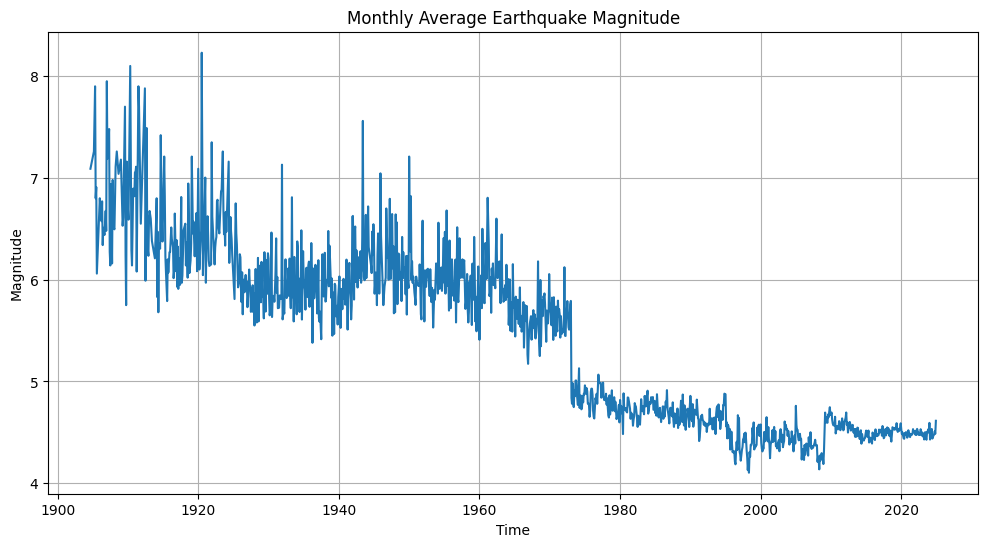

In [32]:
# preprocess data
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')
df.set_index('time', inplace=True)

# Resample to monthly average magnitude
monthly_mag = df['mag'].resample('M').mean().dropna()

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(monthly_mag)
plt.title('Monthly Average Earthquake Magnitude')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

### Test for Stationarity (ADF Test)
The ADF test checks if the time series is stationary. A p-value below 0.05 means the series is stationary and suitable for modeling. If the p-value is higher, the series is non-stationary and needs differencing before model fitting.

In [34]:
# Perform ADF test
result = adfuller(monthly_mag)

# Print ADF results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretation
if result[1] < 0.05:
    print("The series is stationary. Proceed to model fitting.")
else:
    print("The series is non-stationary. Differencing is needed.")

ADF Statistic: -1.3888205096464403
p-value: 0.5876238168717378
Critical Values: {'1%': np.float64(-3.4353824418821852), '5%': np.float64(-2.863762408248617), '10%': np.float64(-2.567953223847985)}
The series is non-stationary. Differencing is needed.


### Making the Series Stationary Using First-Order Differencing
To address the non-stationarity identified in the original time series of monthly average earthquake magnitudes, I applied first-order differencing. This technique subtracts each data point from its previous value, effectively removing any trend or structural shifts in the mean. The resulting differenced series was then plotted to visually inspect for stationarity. The transformed series now fluctuates around a constant mean, indicating that the data is likely stationary and ready for time series modeling.

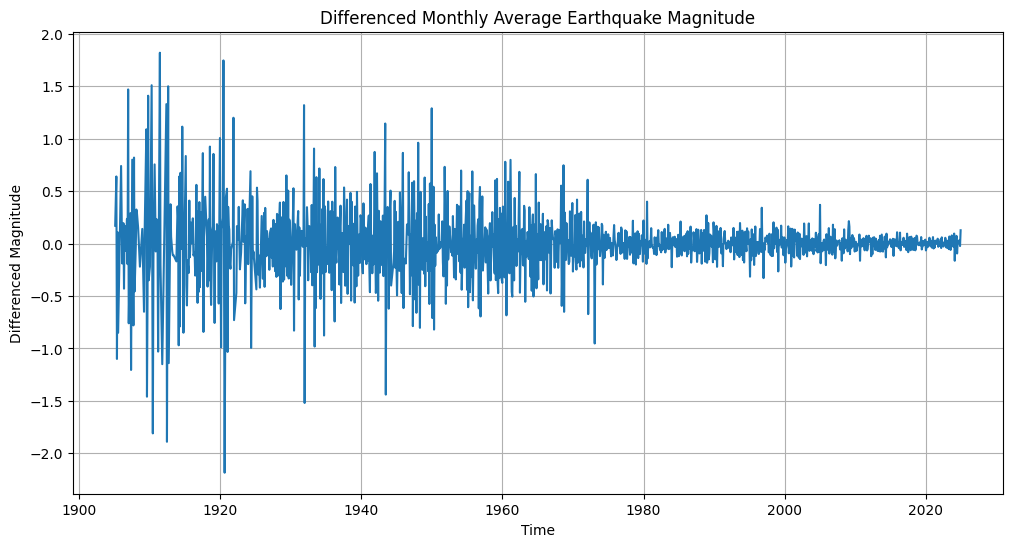

In [35]:
# First-order differencing
monthly_mag_diff = monthly_mag.diff().dropna()

# Plot the differenced series
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_mag_diff)
plt.title('Differenced Monthly Average Earthquake Magnitude')
plt.xlabel('Time')
plt.ylabel('Differenced Magnitude')
plt.grid(True)
plt.show()

#### ADF Test Again (on Differenced Series)
After applying first-order differencing, I ran the ADF test again on the transformed series. The test evaluates whether the differenced data is now stationary. A low p-value (less than 0.05) would indicate that the differenced series is stationary, confirming that the trend component has been successfully removed and the data is now suitable for further modeling using tools like ACF, PACF, and ARIMA.

In [36]:
result_diff = adfuller(monthly_mag_diff)
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value:", result_diff[1])
print("Critical Values:", result_diff[4])

if result_diff[1] < 0.05:
    print("Now the series is stationary, we can proceed with ACF and PACF.")
else:
    print("Still non-stationary. Consider further differencing.")

ADF Statistic (Differenced): -10.749028659886239
p-value: 2.694979246213198e-19
Critical Values: {'1%': np.float64(-3.4353824418821852), '5%': np.float64(-2.863762408248617), '10%': np.float64(-2.567953223847985)}
Now the series is stationary, we can proceed with ACF and PACF.


### Plot ACF and PACF and their table with Test statistic value
I plotted the ACF and PACF of the differenced series to identify potential AR and MA terms. Alongside, I generated a statistical table for the first 20 lags, showing ACF and PACF values with corresponding significance tests. Significant spikes (p-value < 0.05) help in selecting suitable lags for ARIMA modeling.

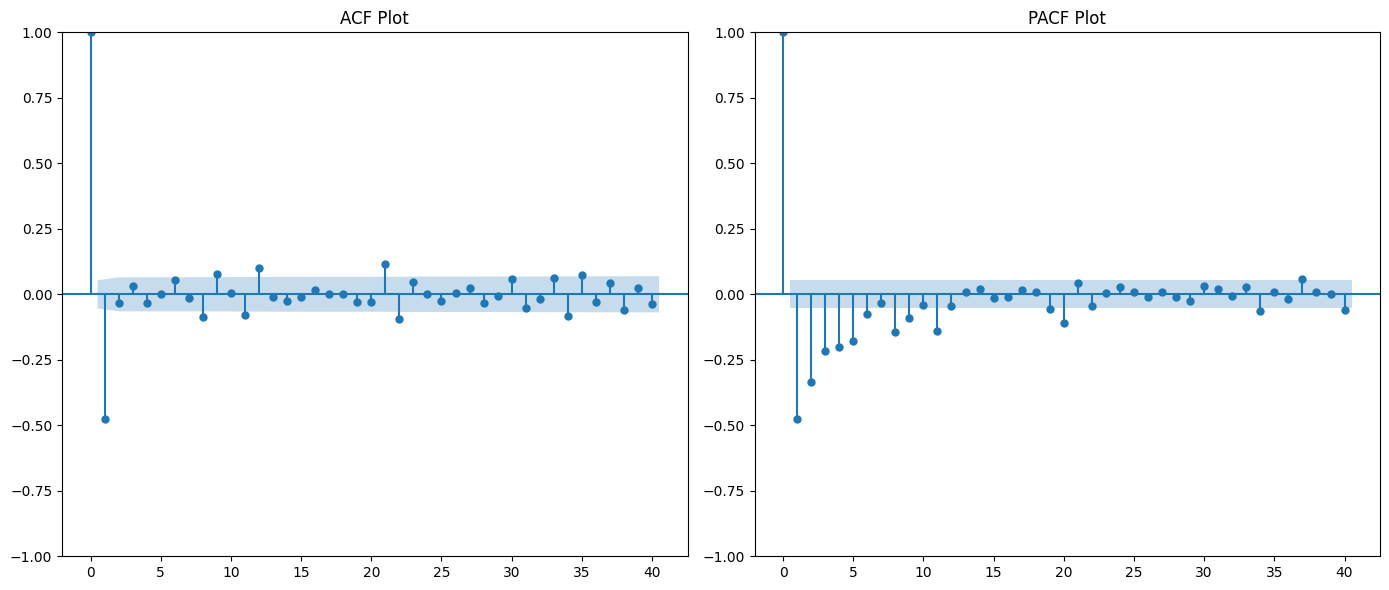

    Lag       ACF  Q-Statistic     Q p-value  PACF (phi_hat)  Z-Statistic  \
0     1 -0.475317   299.804545  3.633746e-67       -0.475676   -17.308340   
1     2 -0.033040   301.254284  3.832335e-66       -0.335204   -12.197008   
2     3  0.030791   302.514340  2.841760e-65       -0.217829    -7.926103   
3     4 -0.033627   304.018277  1.472269e-64       -0.200488    -7.295124   
4     5  0.002519   304.026724  1.364270e-63       -0.179258    -6.522628   
5     6  0.053770   307.877930  1.676742e-63       -0.078088    -2.841376   
6     7 -0.014921   308.174718  1.085448e-62       -0.033204    -1.208179   
7     8 -0.088433   318.607516  4.487327e-64       -0.146501    -5.330722   
8     9  0.076827   326.487743  6.204777e-65       -0.091260    -3.320665   
9    10  0.006089   326.537281  3.762142e-64       -0.044175    -1.607397   
10   11 -0.080210   335.139799  3.365831e-65       -0.142873    -5.198677   
11   12  0.100991   348.787607  2.527937e-67       -0.046649    -1.697414   

In [43]:
# ---------- ACF and PACF Plot ----------
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(monthly_mag_diff, lags=40, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(1, 2, 2)
plot_pacf(monthly_mag_diff, lags=40, ax=plt.gca(), method='ywm')
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

# ---------- ACF and PACF Statistical Table (Top 20 Lags) ----------
n = len(monthly_mag_diff)

# ACF values and Ljung-Box Q statistics
acf_vals = acf(monthly_mag_diff, nlags=20, fft=False)
ljung = acorr_ljungbox(monthly_mag_diff, lags=20, return_df=True)

acf_df = pd.DataFrame({
    'Lag': range(1, 21),
    'ACF': acf_vals[1:21],
    'Q-Statistic': ljung['lb_stat'].values,
    'Q p-value': ljung['lb_pvalue'].values
})

# PACF values and z-tests
pacf_vals = pacf_yw(monthly_mag_diff, nlags=20)
se = 1 / np.sqrt(n)
z_vals = pacf_vals[1:21] / se
p_vals = 2 * (1 - norm.cdf(np.abs(z_vals)))

pacf_df = pd.DataFrame({
    'Lag': range(1, 21),
    'PACF (phi_hat)': pacf_vals[1:21],
    'Z-Statistic': z_vals,
    'Z p-value': p_vals
})

# Merge tables and show
final_df = pd.merge(acf_df, pacf_df, on='Lag')
print(final_df)

#### Compare AIC/BIC for ARMA Models
To identify the best-fitting ARMA model, I performed a grid search over combinations of AR (p) and MA (q) terms, ranging from 0 to 3. For each valid model, the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) were computed. The results were sorted based on AIC values to prioritize models that balance goodness of fit with complexity.

In [46]:
# Store results here
results_table = []

# Try p and q in range 0 to 3
for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(monthly_mag_diff, order=(p, 0, q)).fit()
            results_table.append({
                'p': p,
                'q': q,
                'AIC': model.aic,
                'BIC': model.bic
            })
        except:
            continue  # Skip models that fail

# Convert to DataFrame and sort
results_df = pd.DataFrame(results_table)
results_df = results_df.sort_values('AIC')

# Display top models
print(results_df.head(50))

    p  q         AIC         BIC
1   0  1   66.180477   81.745715
2   0  2   67.583382   88.337033
5   1  1   67.606120   88.359771
6   1  2   69.019892   94.961956
3   0  3   69.205309   95.147373
9   2  1   69.246794   95.188858
10  2  2   70.899358  102.029835
7   1  3   71.019308  102.149784
13  3  1   71.116814  102.247290
11  2  3   72.858547  109.177436
14  3  2   72.865384  109.184273
15  3  3   74.639998  116.147300
12  3  0  213.587127  239.529190
8   2  0  275.112778  295.866429
4   1  0  431.522235  447.087473
0   0  0  768.456053  778.832878


#### Interpretation
Based on the AIC and BIC values from the model selection process, the ARMA(0, 1) model (p = 0, q = 1) has the lowest AIC (66.18) and BIC (81.75), making it the best candidate among all the tested configurations.

### Fitting Final ARMA(0,1) Model on Stationary Series
I fitted an ARMA(0,1) model to the first-order differenced time series of monthly average earthquake magnitudes. The model shows a strong and statistically significant MA(1) component, indicating short-term dependencies in the data. Although the constant term is nearly zero and not strongly significant, the overall model fit is solid, as reflected by the low AIC and BIC values.

In [47]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARMA(0,1) on first-order differenced series
model = ARIMA(monthly_mag_diff, order=(0, 0, 1))
result = model.fit()

# Show summary of the model
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                    mag   No. Observations:                 1324
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -30.090
Date:                Fri, 23 May 2025   AIC                             66.180
Time:                        15:54:39   BIC                             81.746
Sample:                             0   HQIC                            72.015
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.750      0.080      -0.004       0.000
ma.L1         -0.8567      0.011    -78.484      0.000      -0.878      -0.835
sigma2         0.0612      0.001     51.529      0.0

#### Interpretation
The MA(1) term is significant → there's a strong moving average component.
Residuals are uncorrelated (passes Ljung-Box test).
Forecasting with this model is valid from a statistical dependency perspective.


####  Check Diagnostics

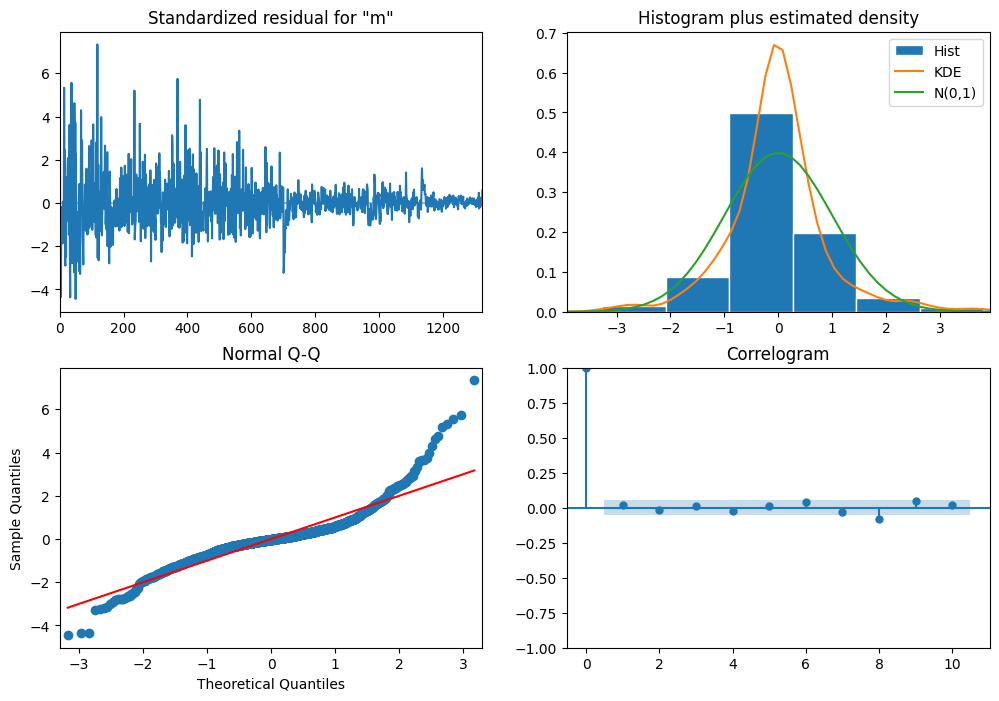

In [23]:
import matplotlib.pyplot as plt

# Plot diagnostics to check residuals
result.plot_diagnostics(figsize=(12, 8))
plt.show()

#### Interpretation:
The standardized residual plot shows that residuals are not constant over time—there’s high variance in the beginning which stabilizes later. This suggests possible model underfitting or heteroskedasticity. The model may need improvement or a variance-stabilizing transformation.

Residuals are close to normally distributed. The ARMA model is mostly appropriate, but some non-normality may be present.

In Normal Q-Q plot, the points deviate from the red straight line, especially at the tails. This indicates that the residuals are not perfectly normally distributed. There may be heavy tails or skewness, violating the normality assumption.

Residuals appear to be uncorrelated (white noise), except possibly at lag 1. The ARMA model has captured the autocorrelation structure well. Minor adjustment may improve it further.

### Forecasting
Using the fitted ARMA(0,1) model, I forecasted the next 12 months of changes in monthly average earthquake magnitudes. These forecasts were initially on the differenced scale, so I converted them back to the original scale by cumulatively summing the predicted values and adding them to the last observed magnitude.

The resulting forecast series was plotted alongside the historical data. The plot illustrates both the observed trend and the projected trajectory, providing insight into how average earthquake magnitudes may evolve in the coming year based on past patterns.

This forecast assumes that the underlying structure captured by the model remains consistent, and it can serve as a baseline for seismic activity monitoring or further refinement.

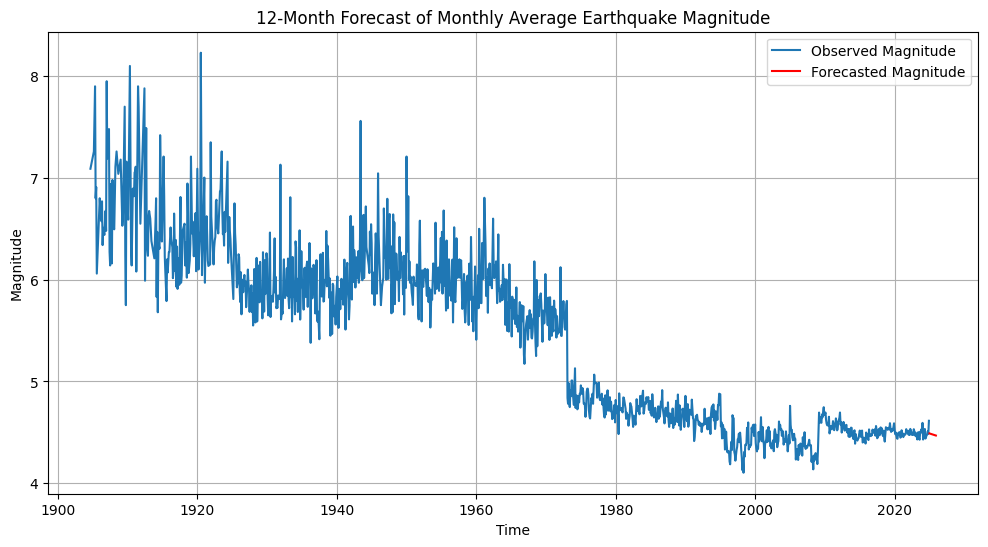

In [24]:
# Step 1: Forecast next 12 months (differenced values)
forecast = result.get_forecast(steps=12)
forecast_diff = forecast.predicted_mean  # Forecasted changes in magnitude

# Step 2: Get the last actual magnitude before forecast begins
last_actual_mag = monthly_mag.iloc[-1]

# Step 3: Convert differenced forecast back to actual magnitudes
forecast_original = forecast_diff.cumsum() + last_actual_mag

# Step 4: Combine past data with forecast
forecast_index = pd.date_range(start=monthly_mag.index[-1] + pd.offsets.MonthBegin(),
                               periods=12, freq='M')
forecast_original.index = forecast_index

# Step 5: Plot forecasted actual magnitudes
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_mag, label='Observed Magnitude')
plt.plot(forecast_original, label='Forecasted Magnitude', color='red')
plt.title('12-Month Forecast of Monthly Average Earthquake Magnitude')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusion:
The ARMA model captures the overall trend.

Forecasts suggest no expected spike in earthquake magnitude in the near future.

This implies model stability, but trend changes or external factors may need to be accounted for using more complex models like ARIMA, SARIMA, or structural time series models if needed.